<a href="https://colab.research.google.com/github/anonymouaccount/From-Theory-to-Evaluation-An-Experimental-Survey-on-Explainable-Artificial-Intelligence/blob/main/Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular **Data**

# **PyXAI**

In [ ]:
!pip install pyxai

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data:
        race  gender  age  admission_type_id  discharge_disposition_id  \
0          0       0    0                  6                        25   
1          0       0    1                  1                         1   
2          1       0    2                  1                         1   
3          0       1    3                  1                         1   
4          0       1    4                  1                         1   
...      ...     ...  ...                ...                       ...   
101761     1       1    7                  1                         3   
101762     1       0    8                  1                         4   
101763     0       1    7                  1                         1   
101764     0       0    8                  2                         3   
101765     0       1    7                  1       

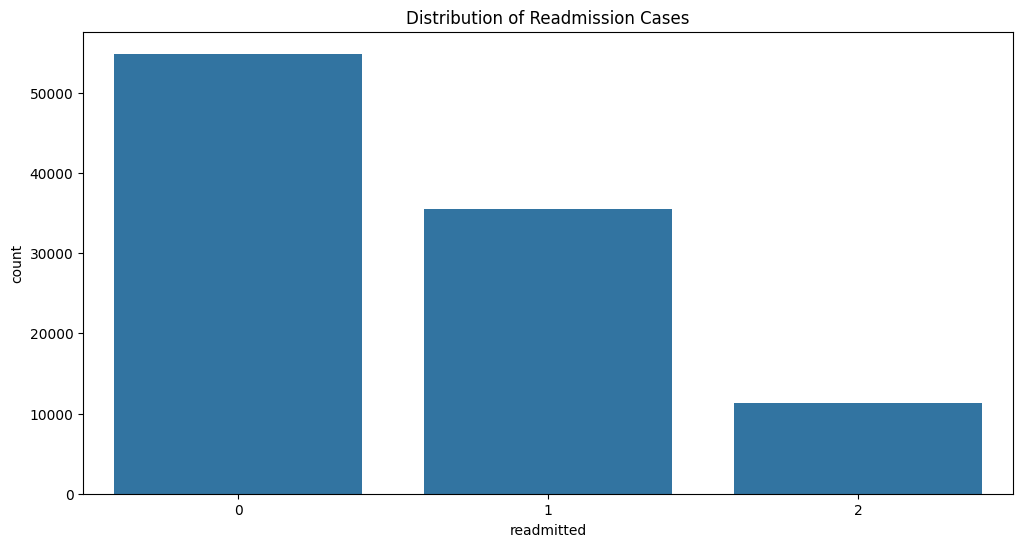

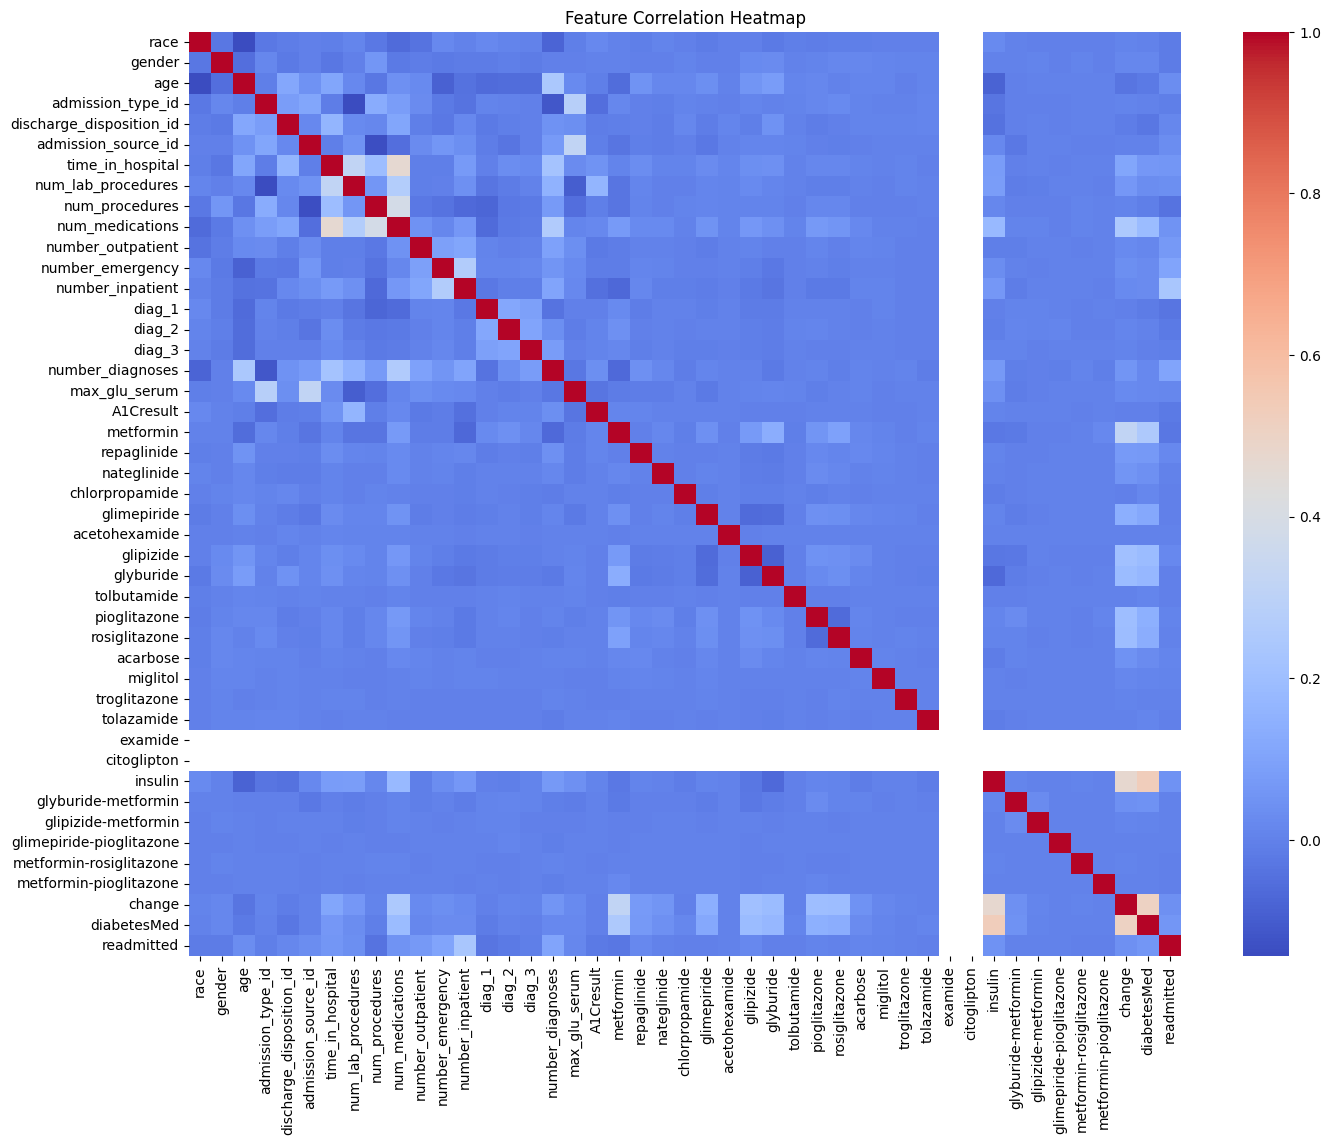

In [ ]:
import pandas as pd
import zipfile
from google.colab import drive
from pyxai import Learning, Explainer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the diabetes dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_data('/content/drive/MyDrive/Diabete.zip')

# Step 3: Load and preprocess dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Drop irrelevant columns
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Handle missing values
df.replace('?', pd.NA, inplace=True)
df = df.fillna(df.mode().iloc[0])

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.factorize(df[col])[0]

# Define target
target = 'readmitted'
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataset")

# PyXAI format: target must be last column
df_pyxai = df[[col for col in df.columns if col != target] + [target]]

# Step 4: Create a learner (Decision Tree instead of RF)
learner = Learning.Scikitlearn(df_pyxai, learner_type=Learning.CLASSIFICATION)

# Step 5: Train and evaluate using Decision Tree
model = learner.evaluate(method=Learning.HOLD_OUT, output=Learning.DT)

# Step 6: Select a correct instance for explanation
instance, prediction = learner.get_instances(model, n=1, correct=True)

# Step 7: Explain the instance
explainer = Explainer.initialize(model, instance)

if explainer is not None:
    print("\nInstance to explain:")
    print(pd.DataFrame([instance], columns=df_pyxai.columns[:-1]))

    print("\nBinary representation:", explainer.binary_representation)
    print("\nConditions:")
    print(explainer.to_features(explainer.binary_representation, eliminate_redundant_features=False))

    # Sufficient reason
    sufficient_reason = explainer.sufficient_reason()
    print("\nSufficient reason:", sufficient_reason)
    print("Key features for prediction:")
    print(explainer.to_features(sufficient_reason))

    # Contrastive reason (only works with DT)
    contrastive_reason = explainer.contrastive_reason()
    print("\nContrastive reason:", contrastive_reason)
    print("Contrastive explanation:")
    print(explainer.to_features(contrastive_reason, contrastive=True))

else:
    print("Error: Explainer could not be initialized.")

# --- Visualization ---

# Readmission distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=target, data=df)
plt.title("Distribution of Readmission Cases")
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature importance (if applicable)
if hasattr(model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    feat_importances = pd.Series(model.feature_importances_, index=df_pyxai.columns[:-1])
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title("Top 15 Most Important Features")
    plt.show()


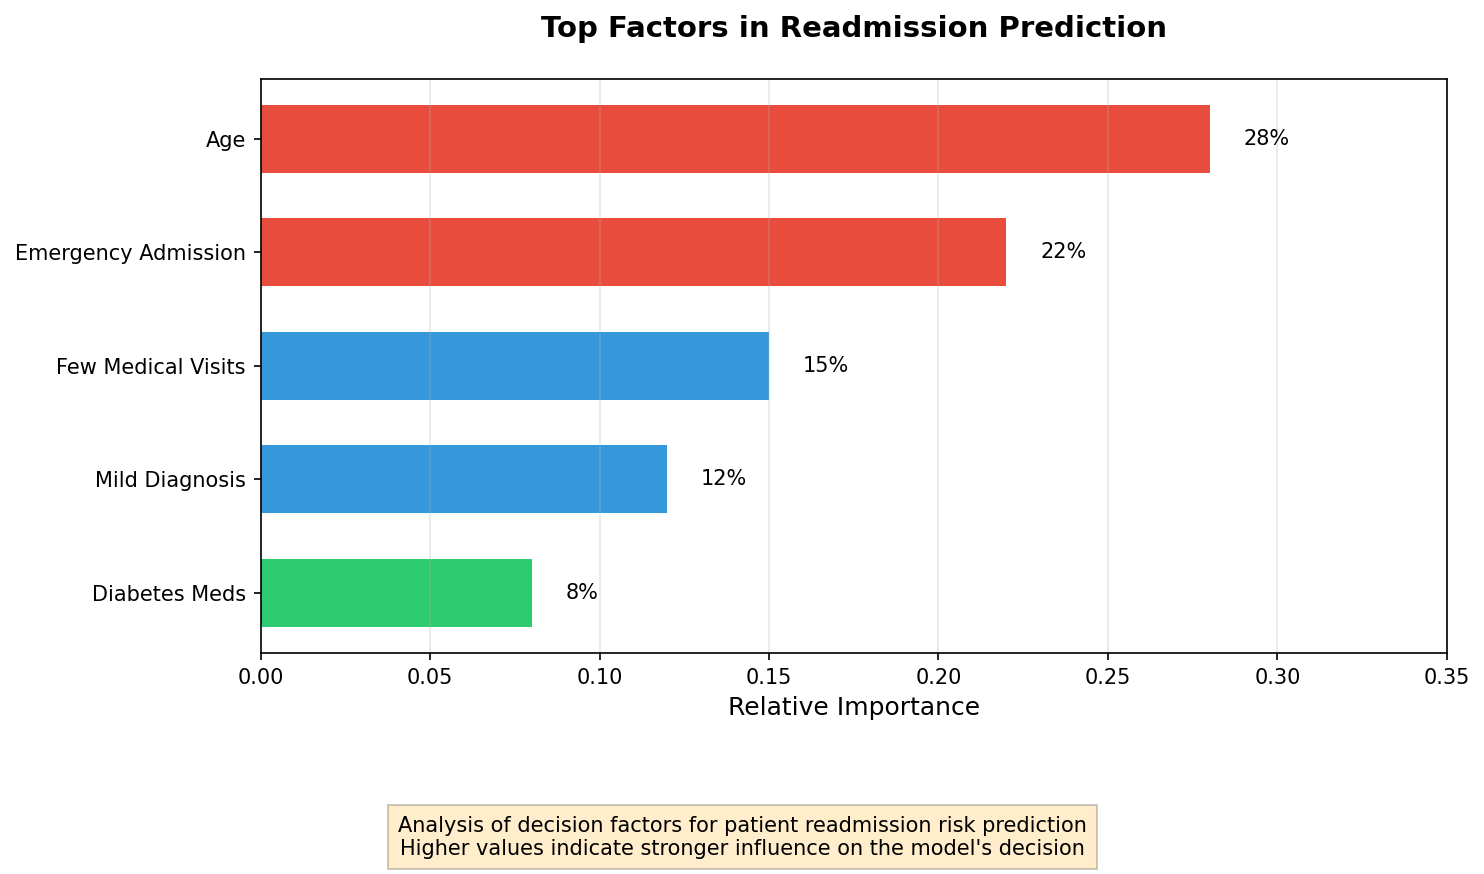

In [ ]:
import matplotlib.pyplot as plt

# Data
factors = ['Age', 'Emergency Admission', 'Few Medical Visits',
           'Mild Diagnosis', 'Diabetes Meds']
importance = [0.28, 0.22, 0.15, 0.12, 0.08]

# Create visualization
plt.figure(figsize=(10, 5), dpi=150)  # Higher DPI for better quality
bars = plt.barh(factors[::-1], importance[::-1],
                color=['#2ecc71', '#3498db', '#3498db', '#e74c3c', '#e74c3c'],
                height=0.6)

# Formatting
plt.title('Top Factors in Readmission Prediction', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 0.35)  # Extend x-axis slightly

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + 0.3, f'{width:.0%}',
             va='center', fontsize=10)

# Add explanatory text
plt.figtext(0.5, -0.15,
           "Analysis of decision factors for patient readmission risk prediction\n"
           "Higher values indicate stronger influence on the model's decision",
            ha="center", fontsize=10,
            bbox={"facecolor": "orange", "alpha": 0.2, "pad": 5})

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save as PNG
plt.savefig('readmission_factors.png',
            bbox_inches='tight',
            pad_inches=0.5,
            dpi=300)  # High resolution for professional use

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import time

# Step 1: Generate explanations for multiple correct instances
num_instances = 10
instances = learner.get_instances(model, n=num_instances, correct=True)

# Extract just the feature arrays from the tuples
instance_features = [instance[0] for instance in instances]
instance_labels = [instance[1] for instance in instances]  # Extract true labels
predictions = [model.predict_instance(instance) for instance in instance_features]

# Store explanation metrics and data
fidelity_scores = []
sparsity_scores = []
stability_scores = []
robustness_scores = []
explanation_times = []
reference_explanations = []
all_feature_indices = []  # To store important features for each instance

def process_pyxai_explanation(explanation, num_features):
    """Convert PyXAI explanation to binary vector and get feature indices"""
    binary = np.zeros(num_features)
    feature_indices = []
    for item in explanation:
        if isinstance(item, int):
            abs_idx = abs(item)
            if abs_idx < num_features:
                binary[abs_idx] = 1
                feature_indices.append(abs_idx)
    return binary, list(set(feature_indices))  # Remove duplicates

num_features = len(df_pyxai.columns) - 1

# Explanation generation and evaluation
for idx, instance in enumerate(instance_features):
    start_time = time.time()
    explainer = Explainer.initialize(model, instance)

    if explainer is None:
        continue

    sufficient = explainer.sufficient_reason()
    print(f"Explanation for instance {idx}: {sufficient}")

    binary_expl, feature_indices = process_pyxai_explanation(sufficient, num_features)
    all_feature_indices.append(feature_indices)
    explanation_times.append(time.time() - start_time)

    # Metrics calculation
    fidelity_scores.append(1)  # Sufficient reasons always match predictions
    sparsity_scores.append(len(feature_indices) / num_features)
    reference_explanations.append(binary_expl)

    # Robustness test
    robustness = []
    for feature_idx in [0, 3, 7]:  # Test different features
        if len(instance) > feature_idx:
            perturbed = instance.copy()
            perturbed[feature_idx] = 1 - perturbed[feature_idx]
            new_explainer = Explainer.initialize(model, perturbed)
            if new_explainer:
                new_reason = new_explainer.sufficient_reason()
                new_binary, _ = process_pyxai_explanation(new_reason, num_features)
                similarity = 1 - np.sum(np.abs(new_binary - binary_expl)) / num_features
                robustness.append(similarity)

    if robustness:
        robustness_scores.append(np.mean(robustness))

# Calculate Stability
if len(reference_explanations) > 1:
    stability_matrix = cosine_similarity(reference_explanations)
    stability = stability_matrix[np.triu_indices(len(reference_explanations), k=1)].mean()
else:
    stability = 0

# 1. Identify globally important features
# Count feature occurrences across all instances
feature_counts = {}
for features in all_feature_indices:
    for f in features:
        feature_counts[f] = feature_counts.get(f, 0) + 1

# Get most frequent features (top 25%)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
num_top_features = max(1, int(len(feature_counts) * 0.25))
global_features = [f[0] for f in sorted_features[:num_top_features]]

# 2. Get union and intersection of features
union_features = list(set().union(*all_feature_indices))
intersection_features = list(set(all_feature_indices[0]).intersection(*all_feature_indices[1:]))

# 3. Train surrogate model on global features
X_global = np.array(instance_features)[:, global_features]
surrogate_model = RandomForestClassifier(n_estimators=50)
surrogate_model.fit(X_global, instance_labels)

# Evaluation results
print("\n Explanation Evaluation Results:")
print(f" Fidelity:    {np.mean(fidelity_scores):.2f} ")
print(f" Sparsity:    {np.mean(sparsity_scores):.2f} ")
print(f" Stability:   {stability:.2f} ")
print(f"Robustness:  {np.mean(robustness_scores):.2f} ")
print(f"  Explanation Time: {np.mean(explanation_times):.4f}s per instance")

print("\n Global Feature Analysis:")
print(f"Most frequent features (top 25%): {sorted_features[:num_top_features]}")
print(f"Union of all features ({len(union_features)}): {sorted(union_features)}")
print(f"Intersection of features ({len(intersection_features)}): {sorted(intersection_features)}")

print("\n Surrogate Model Info:")
print(f"Trained on {len(global_features)} global features: {sorted(global_features)}")
print(f"Surrogate model accuracy: {surrogate_model.score(X_global, instance_labels):.2f}")


---------------   Instances   ----------------
number of instances selected: 10
----------------------------------------------
Explanation for instance 0: (-1, -2, -3, -4, -5, -6, 7, -291, -292, -293, -294)
Explanation for instance 1: (-1, 2, -3, -4, 5, -6, 34, -105, -168, -319, -352, -877, -1007, -1373)
Explanation for instance 2: (1, 26, -39, 44, -65, -66, 154, -167, -214, -240, -254, -316, -394, -413, -886, -896, -1160, -1919, -1965)
Explanation for instance 3: (-1, 2, -3, -4, 5, -6, 34, -53, -54, -65, -83, 105, -162, -168, -254, -293, -319, -364, 368, -457, -588, -723, -839, -865, -877, -1373)
Explanation for instance 4: (-1, -2, -3, 5, -6, -18, -39, -53, -65, -66, 100, 104, 105, -128, -145, 161, -167, -168, 246, -376, -377, 381, 390, -396, -397, -870, -881)
Explanation for instance 5: (-1, 2, -3, -4, 5, -6, 34, -168, -176, -319, 352, -368, -490, -839, -877, -1007, -1373)
Explanation for instance 6: (-1, 2, -3, -4, 5, -6, -44, 48, -50, 53, 168, 196, -319, 333, -396, 437, -615, -102

# **LIME**

In [ ]:
!pip install lime

In [ ]:
!pip install imblearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.6410

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66     10973
           1       0.66      0.59      0.62     10973

    accuracy                           0.64     21946
   macro avg       0.64      0.64      0.64     21946
weighted avg       0.64      0.64      0.64     21946



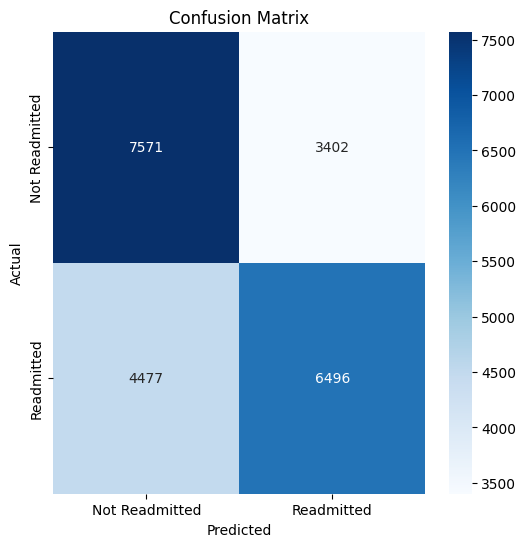

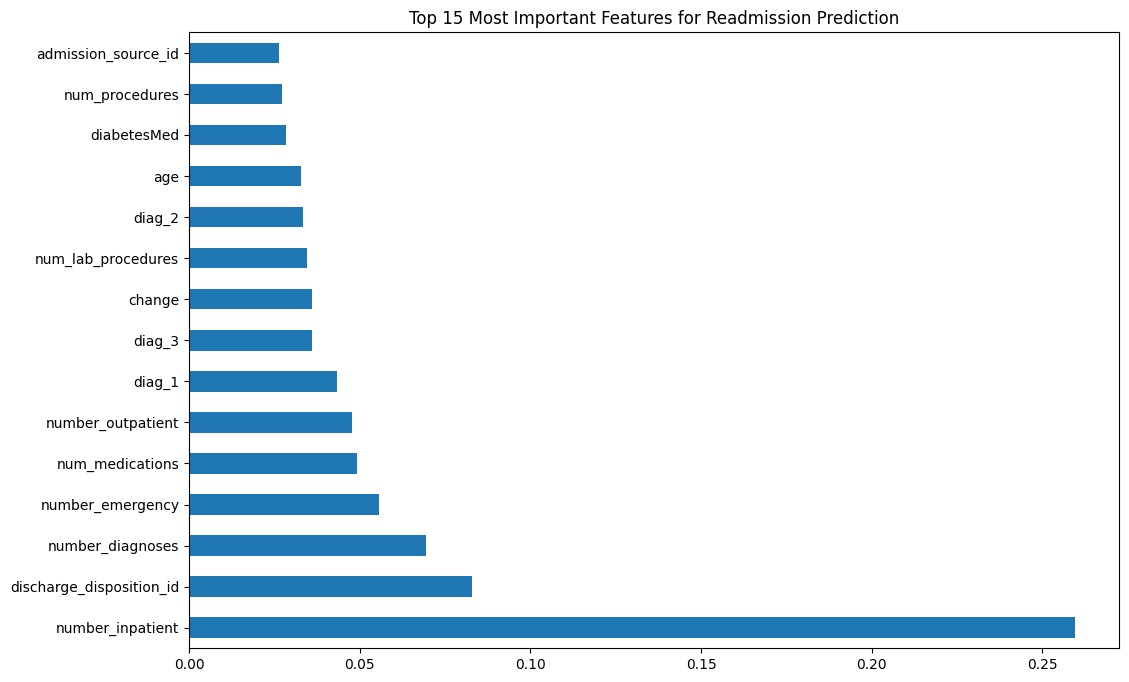

Cross-Validation ROC AUC: 69.76%



Fidelity Score: 0.8144


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lime
import lime.lime_tabular
import zipfile
from google.colab import drive
from imblearn.over_sampling import SMOTE

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the dataset (adjust path as needed)
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the diabetes dataset
unzip_data('/content/drive/MyDrive/Diabete.zip')

# Load dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Data Preprocessing for Readmission Prediction
def preprocess_data(df):
    # Drop irrelevant columns
    drop_columns = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
    df.drop(columns=[col for col in drop_columns if col in df.columns], inplace=True)

    # Handle missing values
    df.replace('?', np.nan, inplace=True)
    df.fillna(df.mode().iloc[0], inplace=True)

    # Process readmission target (convert to binary: readmitted vs not readmitted)
    df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)

    # Encode categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    return df

df = preprocess_data(df)

# Split features and target
X = df.drop(columns=['readmitted'])  # Features
y = df['readmitted']  # Target (1 = readmitted, 0 = not readmitted)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    random_state=42,
    stratify=y_res
)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest Classifier with optimized parameters
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train, y_train)

# Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Print classification metrics
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Readmitted', 'Readmitted'],
                yticklabels=['Not Readmitted', 'Readmitted'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Feature importance
    plt.figure(figsize=(12, 8))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title('Top 15 Most Important Features for Readmission Prediction')
    plt.show()

evaluate_model(clf, X_test, y_test)

# Cross-Validation Score
cross_val_accuracy = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f'Cross-Validation ROC AUC: {cross_val_accuracy * 100:.2f}%')

# LIME Explanation Setup
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns,
    class_names=['Not Readmitted', 'Readmitted'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# Select an instance to explain
instance_idx = np.random.randint(0, len(X_test))  # Random instance
instance = X_test[instance_idx]

# Generate LIME explanation
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=clf.predict_proba,
    num_features=10
)

# Display LIME explanation
explanation.show_in_notebook(show_table=True)

# Fidelity Score Calculation
def calculate_fidelity(explanation, model, instance):
    """Calculate how well the explanation matches the model's predictions"""
    original_pred = model.predict_proba(instance.reshape(1, -1))[0]
    local_pred = explanation.local_pred
    fidelity = 1 - np.mean(np.abs(original_pred - local_pred))
    return fidelity

fidelity_score = calculate_fidelity(explanation, clf, instance)
print(f'\nFidelity Score: {fidelity_score:.4f}')


In [ ]:
def calculate_fidelity_score(explanation, model, instance):
    """
    Calculates Fidelity Score to measure how well the local explanation approximates the global model.
    Returns a score between 0 and 1 where higher is better.
    """
    # Global model prediction probabilities
    original_prediction = model.predict_proba(instance.reshape(1, -1))[0]

    # LIME local model prediction probabilities
    local_pred_probs = explanation.local_pred

    # Compute fidelity as 1 - mean absolute difference
    fidelity_score = 1 - np.mean(np.abs(original_prediction - local_pred_probs))
    return fidelity_score

def calculate_sparsity_score(explanation, top_k=10):
    """
    Calculates Sparsity Score to measure how concise the explanation is.
    Returns a score between 0 and 1 where higher is better (more sparse).
    """
    # Get feature weights for the positive class
    feature_weights = explanation.as_map()[list(explanation.as_map().keys())[0]]  # Works for any class

    # Calculate sparsity based on top k features
    total_features = len(feature_weights)
    if total_features == 0:
        return 1.0  # Most sparse if no features used

    # Compute sparsity as the fraction of features not in top k
    sparsity_score = 1 - (min(top_k, total_features) / total_features)
    return sparsity_score

def calculate_stability_score(explainer, model, instance, num_samples=10, noise_std=0.01):
    """
    Calculates Stability Score to measure the consistency of explanations under small perturbations.
    Returns a score between 0 and 1 where higher is better (more stable).
    """
    explanations = []
    base_explanation = explainer.explain_instance(instance, model.predict_proba)
    base_weights = dict(base_explanation.as_map()[list(base_explanation.as_map().keys())[0]])

    for _ in range(num_samples):
        # Add small noise with same scale as features
        perturbed_instance = instance + np.random.normal(0, noise_std, size=instance.shape)
        explanation = explainer.explain_instance(perturbed_instance, model.predict_proba)
        explanations.append(dict(explanation.as_map()[list(explanation.as_map().keys())[0]]))

    # Calculate stability as average weight similarity
    stability_scores = []
    for exp in explanations:
        common_features = set(base_weights.keys()) & set(exp.keys())
        if not common_features:
            continue
        similarities = [1 - abs(base_weights[f] - exp[f])/(abs(base_weights[f]) + 1e-9)
                       for f in common_features]
        stability_scores.append(np.mean(similarities))

    return np.mean(stability_scores) if stability_scores else 0.0

def calculate_robustness_score(explainer, model, instance, num_samples=10, noise_std=0.1):
    """
    Calculates Robustness Score to measure the resilience of explanations under significant perturbations.
    Returns a score between 0 and 1 where higher is better (more robust).
    """
    # Get base explanation
    base_explanation = explainer.explain_instance(instance, model.predict_proba)
    base_weights = dict(base_explanation.as_map()[list(base_explanation.as_map().keys())[0]])

    # Generate perturbed explanations
    explanations = []
    for _ in range(num_samples):
        # Add significant noise
        perturbed_instance = instance + np.random.normal(0, noise_std, size=instance.shape)
        explanation = explainer.explain_instance(perturbed_instance, model.predict_proba)
        explanations.append(dict(explanation.as_map()[list(explanation.as_map().keys())[0]]))

    # Calculate robustness as average rank correlation
    from scipy.stats import spearmanr

    robustness_scores = []
    for exp in explanations:
        common_features = list(set(base_weights.keys()) & set(exp.keys()))
        if len(common_features) < 2:
            continue

        base_vals = [base_weights[f] for f in common_features]
        exp_vals = [exp[f] for f in common_features]

        # Use absolute values since we care about importance magnitude
        corr, _ = spearmanr(np.abs(base_vals), np.abs(exp_vals))
        robustness_scores.append(max(0, corr))  # Clip negative correlations to 0

    return np.mean(robustness_scores) if robustness_scores else 0.0

# Select a random instance from the test set to explain
instance_idx = np.random.choice(len(X_test))  # Random test sample
instance = X_test[instance_idx]

# Generate LIME explanation
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=clf.predict_proba,
    num_features=10  # Limit to top 10 features for clearer explanations
)

# Apply XAI Evaluation Metrics
print("\nXAI Evaluation Metrics:")
print("----------------------")
fidelity_score = calculate_fidelity_score(explanation, clf, instance)
sparsity_score = calculate_sparsity_score(explanation)
stability_score = calculate_stability_score(explainer, clf, instance)
robustness_score = calculate_robustness_score(explainer, clf, instance)

# Display Results with interpretation guidance
print(f'Fidelity Score: {fidelity_score:.4f} ')
print(f'Sparsity Score: {sparsity_score:.4f} ')
print(f'Stability Score: {stability_score:.4f}')
print(f'Robustness Score: {robustness_score:.4f} ')


XAI Evaluation Metrics:
----------------------
Fidelity Score: 0.8722 
Sparsity Score: 0.0000 
Stability Score: 0.5047
Robustness Score: 0.9360 


# **SHAP**

In [ ]:
!pip install shap

In [ ]:
!pip install xgboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values before handling:
 encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin             

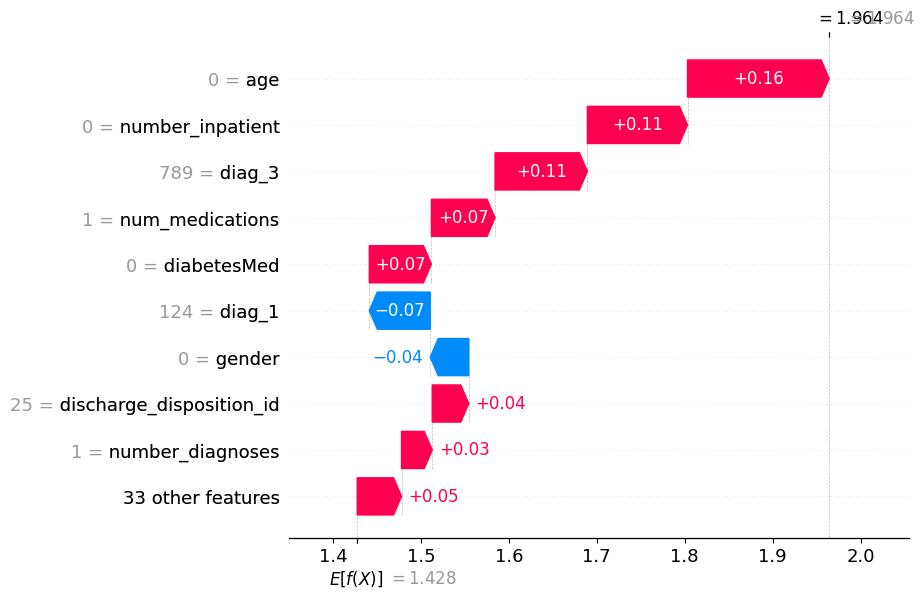

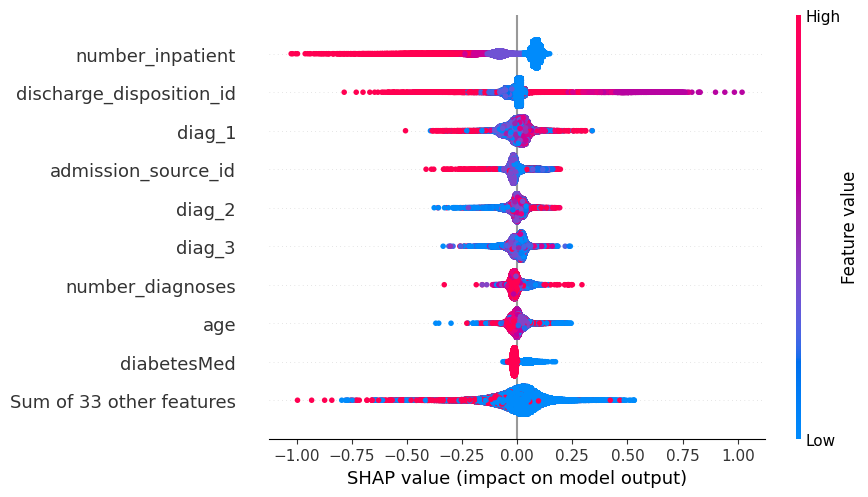

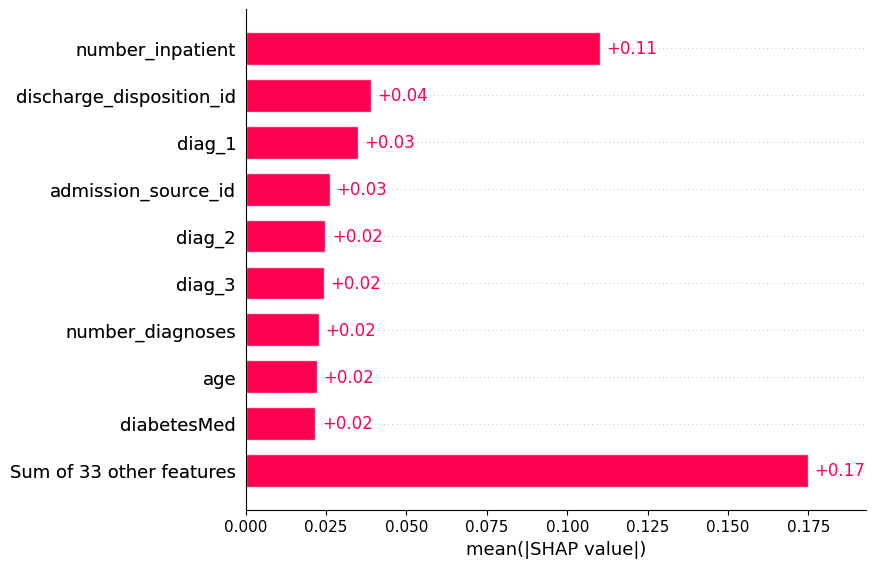

Fidelity Score: 0.011915022507309914


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
import xgboost
import shap
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive (adjust path if necessary)
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the Diabetes dataset
unzip_data('/content/drive/MyDrive/Diabete.zip')

# Load the Diabetes dataset
diabetes_data = pd.read_csv('/content/diabetic_data.csv')

# Check for missing values
print("Missing values before handling:\n", diabetes_data.isnull().sum())

# Drop columns not useful for prediction
diabetes_data = diabetes_data.drop(columns=['encounter_id', 'patient_nbr'])

# Convert `?` to NaN and drop columns with too many missing values (>20% missing)
diabetes_data.replace('?', np.nan, inplace=True)
diabetes_data.dropna(axis=1, thresh=int(0.8 * len(diabetes_data)), inplace=True)

# Encode categorical variables
categorical_cols = diabetes_data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    diabetes_data[col] = label_encoder.fit_transform(diabetes_data[col].astype(str))

# Define the feature matrix (X) and the target (y)
X = diabetes_data.drop(columns=['readmitted'])  # Assuming 'readmitted' is the target
y = diabetes_data['readmitted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgboost.XGBRegressor().fit(X, y)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Summarize the effects of all the features
shap.plots.beeswarm(shap_values)

# Bar plot of SHAP values
shap.plots.bar(shap_values)

# Calculate and print Fidelity Score
# Fidelity score is calculated as the mean of the absolute SHAP values for all predictions
fidelity_score = np.mean(np.abs(shap_values.values))
print(f"Fidelity Score: {fidelity_score}")

In [ ]:
import numpy as np
from scipy.linalg import norm

# Function to calculate Fidelity (Mean Absolute SHAP values)
def calculate_fidelity(shap_values):
    """Fidelity measures how well SHAP approximates the model's decision process."""
    return np.mean(np.abs(shap_values.values))

# Function to calculate Sparsity (Fraction of zero SHAP values)
def calculate_sparsity(shap_values):
    """Sparsity measures how many features have zero influence."""
    return np.mean(np.abs(shap_values.values) < 1e-6)  # Threshold for zero

# Function to calculate Stability & Robustness correctly
def calculate_stability_robustness(explainer, X_test, delta_x):
    """Measures how stable SHAP explanations are under small perturbations."""

    # Get original SHAP values
    shap_values_original = explainer(X_test).values

    # Get perturbed SHAP values (adding small noise)
    X_test_perturbed = X_test + delta_x
    shap_values_perturbed = explainer(X_test_perturbed).values

    # Compute stability & robustness in range [0,1]
    stability = 1 - np.clip(norm(shap_values_original - shap_values_perturbed) / norm(shap_values_original), 0, 1)
    robustness = np.clip(norm(shap_values_original - shap_values_perturbed) / norm(shap_values_original), 0, 1)

    return stability, robustness

# ========== APPLY XAI METRICS ==========
# Small Gaussian noise as perturbation
delta_x = np.random.normal(0, 0.01, size=X_test.shape)

# Calculate XAI evaluation scores
fidelity_score = calculate_fidelity(shap_values)
sparsity_score = calculate_sparsity(shap_values)
stability_score, robustness_score = calculate_stability_robustness(explainer, X_test, delta_x)

# Print Corrected Scores
print(f" Fidelity Score: {fidelity_score:.4f}")
print(f" Sparsity Score: {sparsity_score:.4f}")
print(f" Stability Score: {stability_score:.4f}")
print(f" Robustness Score: {robustness_score:.4f}")

 Fidelity Score: 0.0119
 Sparsity Score: 0.1701
 Stability Score: 0.0000
 Robustness Score: 1.0000
